## cRBM hyperparameter optimization by cross-validation

In [1]:
import numpy as np
import torch
import seaborn as sns


import sys
sys.path.append('D:\RU\OneDrive\Intern\Master\RBMs\Codes')

from libs import *
from funcs import *
from RBMs import RBMs
from loaddata import load_data
from plots import *

In [2]:
spikes, behavior, coords, df, stimulus = load_data()

In [3]:
n_hid = 64 # number of neurons in the hidden layer
n_vis = 256 # input size
n_batches_train = 2000 # number of batches to train on
n_batches_test = 880 # number of batches to test on
lamda = 3e-5

spike_thres = 0.15
spikes[spikes>spike_thres] = 1
spikes[spikes<spike_thres] = 0
tmp = np.argsort(np.sum(spikes,0))[::-1]
spikes = spikes[:,tmp]
spikes = spikes.T

V_train = torch.tensor(spikes[:n_vis, :n_batches_train])
V_test = torch.tensor(spikes[:n_vis, n_batches_train:(n_batches_train + n_batches_test)])

<AxesSubplot:>

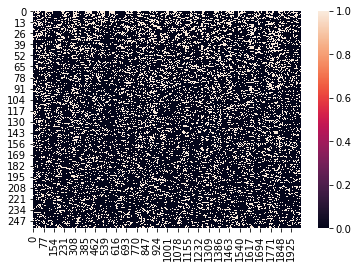

In [4]:
sns.heatmap(V_train)

In [5]:
# create cRBM model
RBM = RBMs(V_train, N_H=n_hid)

# train model
RBM_train = RBM.train_RBM(RBM, V_train, 
                           n_epochs = 1000,
                           learning_rate = 0.01, 
                           momentum = 0.9, 
                           weightcost = 0.0002, 
                           CDk = 1, PCD = False,
                           batchsize = 128,
                           disable_tqdm = False)


# infer model
#V_est, H_est = infer(cRBM_model, V_train, T=2000, method = 'Gibbs') # n_batches_test

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:07<00:00,  1.03s/it]


Text(0, 0.5, 'RMS error')

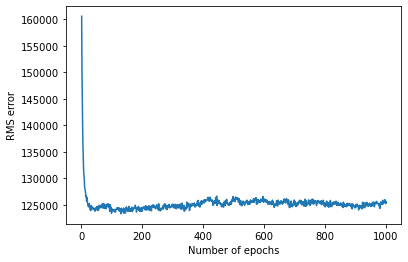

In [7]:
n_epochs = 1000
plt.plot(np.linspace(1,n_epochs,n_epochs), torch.reshape(RBM.errors,[n_epochs])) 
plt.xlabel("Number of epochs")
plt.ylabel("RMS error")

In [10]:
V_est, H_est = RBMs.infer(RBM, V_train.T, T=2000, method = 'Gibbs') # n_batches_test

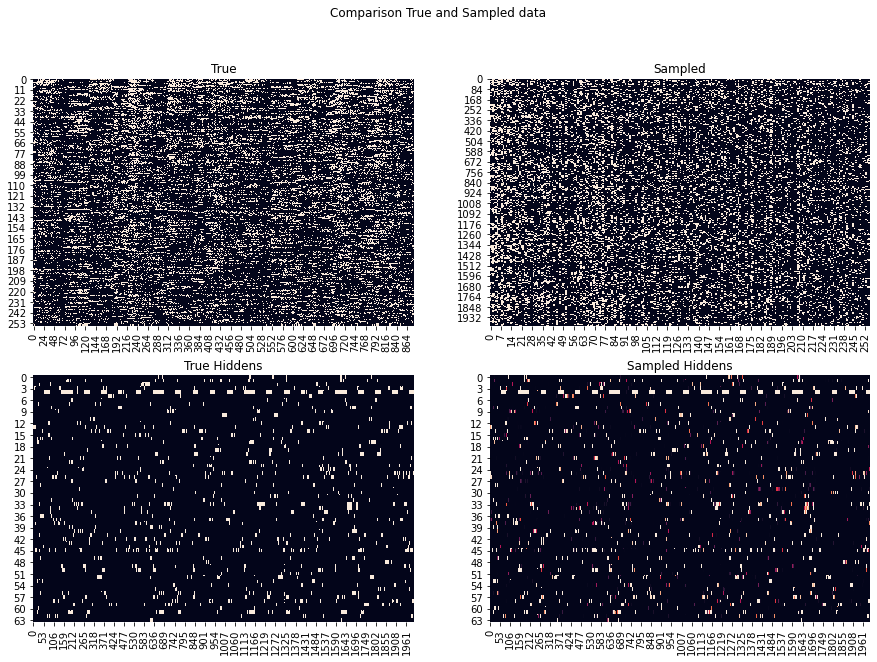

In [11]:
_, H_train = RBM.visible_to_hidden(V_train.T)
H_est, _ = RBM.visible_to_hidden(RBM.v_infer.T)
plot_true_sampled(V_test, H_train.T, V_est, H_est.T)



$\mathrm{RMSE}=\sqrt{\frac{1}{N_{x}} \sum_{n=1}^{N_{x}}\left(x_{1}(n)-x_{2}(n)\right)^{2}}$

$\mathrm{nRMSE}=1-\frac{\mathrm{RMSE}_{\text {ordinary }}-\mathrm{RMSE}_{\text {shuffled }}}{\mathrm{RMSE}_{\text {optimal }}-\mathrm{RMSE}_{\text {shuffled }}}$

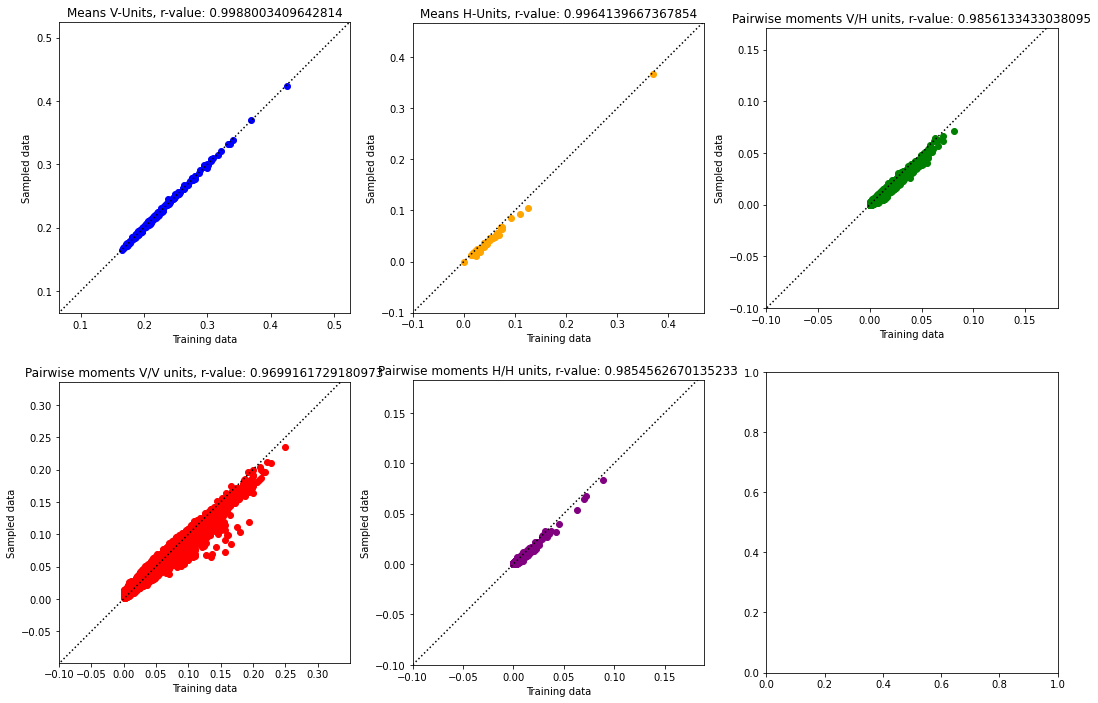

In [12]:
plot_moments(V_train, H_train.T, RBM.v_infer, H_est.T)

In [18]:
#get_nRMSE_moments(RBM, V_train, V_test, RBM.v_infer)

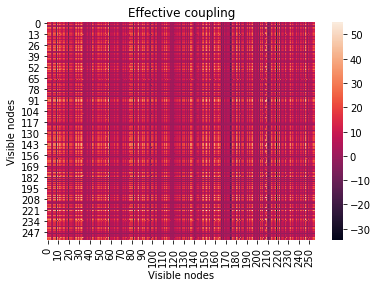

In [21]:
def pairwise_interaction_plot(W, title = 'title'):
    # W.shape = [V, H]
    
    J = torch.outer( torch.sum(W,1), torch.sum(W,1))
    sns.heatmap(J)
    plt.ylabel("Visible nodes")
    plt.xlabel("Visible nodes")
    plt.title(title)
    plt.show()
    return
    
def effective_coupling_plot(W, h, title = 'title'):
    
    var_h_matrix = torch.reshape(torch.var(h,0).repeat(n_vis),[n_vis, n_hid])
    J = torch.outer( torch.sum(W,1), torch.sum(W * var_h_matrix,1)) 
    sns.heatmap(J)
    plt.ylabel("Visible nodes")
    plt.xlabel("Visible nodes")
    plt.title(title)
    plt.show()
    return
h, _ = RBM.visible_to_hidden(V_train.T)
h.shape
effective_coupling_plot(RBM.W, h, 'Effective coupling')

In [ ]:
M_range = [5, 10, 20, 40, 60, 80, 100, 150, 200, 300] # number of hidden units
lamda_range = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2] # sparsity regularization

T_train = 2000 # number of training samples
T_test  = 880  # number of test samples

V_train = torch.tensor(spikes[:n_vis, :T_train])
V_test  = torch.tensor(spikes[:n_vis, n_batches_train:(T_train + T_test)])

V_nRMSE  = torch.zeros(len(M_range), len(lamda_range))
H_nRMSE  = torch.zeros(len(M_range), len(lamda_range))
VH_nRMSE = torch.zeros(len(M_range), len(lamda_range))
VV_nRMSE = torch.zeros(len(M_range), len(lamda_range))
HH_nRMSE = torch.zeros(len(M_range), len(lamda_range))
ewm      = torch.zeros(len(M_range), len(lamda_range))

for i, M in enumerate(M_range):
    for j, lamda in enumerate(lamda_range):
        # create model
        cRBM = RBMs(V_train, N_H=M)

        # train model
        RBM_train = cRBM.train_cRBM(cRBM, V_train, 
                           n_epochs = 1000,
                           learning_rate = 0.01, 
                           momentum = 0.9, 
                           weightcost = 0.0002, 
                           CDk = 10, PCD = False,
                           spars_penalty = j,
                           x = 1,
                           batchsize = 128,
                           disable_tqdm = False)
        
        # estimate using OLS
        #V_est, _ = infer(cRBM_model, V_train, T=n_batches_test)
        
        # get nRMSEs
        V_nRMSE[i,j], H_nRMSE[i,j], VH_nRMSE[i,j], VV_nRMSE[i,j], HH_nRMSE[i,j] = get_nRMSE_moments(cRBM, V_train, V_test, RBM.v_infer)
        
        # element-wise minimum
        ewm[i,j] = torch.min(torch.tensor([V_nRMSE[i,j], H_nRMSE[i,j], VH_nRMSE[i,j], VV_nRMSE[i,j], HH_nRMSE[i,j]]))

In [ ]:
# plot the heatmaps of nRMSEs
fig, axes = plt.subplots(2, 3, figsize=(15,10),sharex=True, sharey=True)
gs = fig.add_gridspec(2, 3)
sns.heatmap(V_nRMSE,  ax=axes[0,0], yticklabels=M_range)
sns.heatmap(H_nRMSE,  ax=axes[0,1])
sns.heatmap(VH_nRMSE, ax=axes[0,2])
sns.heatmap(VV_nRMSE, ax=axes[1,0], xticklabels=lamda_range, yticklabels=M_range)
sns.heatmap(HH_nRMSE, ax=axes[1,1], xticklabels=lamda_range)
sns.heatmap(ewm,      ax=axes[1,2], xticklabels=lamda_range)
axes[1,2].set_title('Element-wise minimum')